# Norway : Lofoten & Lyngen

In [1]:
# Preamble - Execute only once

%load_ext autoreload
%autoreload 2

import os
NBROOT = os.path.realpath(os.curdir)

In [2]:
# Preamble
# mamba install jupyter matplotlib seaborn pandas gdal rasterio pillow shapely pmtiles mercantile
import os
NBROOT = os.path.realpath(os.curdir)

import logging
logging.basicConfig(level=logging.DEBUG)

# stdlib
from os.path import basename, exists, join as pjoin, realpath
from pathlib import Path
from urllib.request import urlretrieve
from zipfile import ZipFile

#external
from IPython.display import Image
#from py7zr import SevenZipFile

# self
from src import bbox, gdal_slope_util as S, ign_mnt_download, mbt_util as M
# from src.gdal_slope_util import check_run, DFLT_OPT, ZSTD_OPT, TILE_OPT

# CPL_ZIP_ENCODING for gdal vsizip:  https://github.com/conda-forge/gdal-feedstock/issues/83
os.environ['CPL_ZIP_ENCODING'] = 'UTF-8'

In [ ]:
# ! wget https://download.mapterhorn.com/6-34-15.pmtiles -O data/dtm_local/nolofoten_trr.pmtiles
# ! wget https://download.mapterhorn.com/6-35-14.pmtiles -O data/dtm_local/nolyngen_trr.pmtiles

--2026-01-14 22:27:06--  https://download.mapterhorn.com/6-34-15.pmtiles
Resolving download.mapterhorn.com (download.mapterhorn.com)... 2606:4700:20::681a:ccc, 2606:4700:20::ac43:479f, 2606:4700:20::681a:dcc, ...
Connecting to download.mapterhorn.com (download.mapterhorn.com)|2606:4700:20::681a:ccc|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16634179240 (15G)
Saving to: ‘data/dtm_local/mapterhorn-6-34-15-no-lofoten.pmtiles’

_local/mapterhorn-6   0%[                    ]  14,58M   423KB/s    eta 6h 53m ^C
--2026-01-14 22:27:31--  https://download.mapterhorn.com/6-35-14.pmtiles
Resolving download.mapterhorn.com (download.mapterhorn.com)... 2606:4700:20::681a:ccc, 2606:4700:20::681a:dcc, 2606:4700:20::ac43:479f, ...
Connecting to download.mapterhorn.com (download.mapterhorn.com)|2606:4700:20::681a:ccc|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21856222651 (20G)
Saving to: ‘data/dtm_local/mapterhorn-6-35-14-no-lyngen.pmtiles’

n

In [ ]:
!ls -l data/dtm_local/nolofoten_trr.pmtiles

-rw-rw-r-- 1 eoubrayrie eoubrayrie 16634179240 déc.  29 18:25 data/dtm_local/mapterhorn-6-34-15-no-lofoten.pmtiles


In [ ]:
!ogrinfo data/dtm_local/nolofoten_trr.pmtiles
!gdalinfo data/dtm_local/nolofoten_trr.pmtiles

ERROR 1: Tile type WEBP not handled by the driver
ERROR 1: Tile type WEBP not handled by the driver
ogrinfo failed - unable to open 'data/dtm_local/mapterhorn-6-34-15-no-lofoten.pmtiles'.
ERROR 4: `data/dtm_local/mapterhorn-6-34-15-no-lofoten.pmtiles' not recognized as being in a supported file format.
gdalinfo failed - unable to open 'data/dtm_local/mapterhorn-6-34-15-no-lofoten.pmtiles'. Did you intend to call ogrinfo?


In [ ]:
!pmtiles-convert data/dtm_local/nolofoten_trr.{pmtiles,mbtiles}
!pmtiles-convert data/dtm_local/nolyngen_trr.{pmtiles,mbtiles}
# 1 minute each the files remain ~20 GB each

In [ ]:
!gdalinfo data/dtm_local/nolofoten_trr.mbtiles | rg -v '    '

Driver: MBTiles/MBTiles
Files: data/dtm_local/nolofoten.mbtiles
Size is 253952, 262144
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
Data axis to CRS axis mapping: 1,2
Origin = (1271912.145099358167499,10644926.281183030456305)
Pixel Size = (2.388657133911758,-2.388657133911758)
Metadata:
  ZOOM_LEVEL=15
  attribution=<a href="https://mapterhorn.com/attribution">© Mapterhorn</a>
  minzoom=13
  maxzoom=15
  bounds=11.4257812,66.5132604,16.875,68.6565549
  center=14.1503906,67.5849076,14
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  ( 1271912.145,10644926.281) ( 11d25'32.81"E, 68d39'23.60"N)
Lower Left  ( 1271912.145,10018754.145) ( 11d25'32.81"E, 66d30'47.74"N)
Upper Right ( 1878516.402,10644926.281) ( 16d52'30.00"E, 68d39'23.60"N)
Lower Right ( 1878516.402,10018754.145) ( 16d52'30.00"E, 66d30'47.74"N)
Band 1 Block=512x512 Type=Byte, ColorInterp=Red
  Overviews: 126976x131072, 63488x65536
  Mask Flags: PER_DATASET ALPHA 
  Overviews of mask ban

In [6]:
def trr2tif(src, dest='', reuse=False):
    """Convert Terrarrium Terrain RGB MBTiles to GeoTIFF."""
    assert dest or src.endswith('trr.mbtiles')
    dest = dest or src.replace('trr.mbtiles', 'dtm.tif')
    if reuse and os.path.exists(dest):
        print('Reuse', dest)
        return dest
    S.check_run(f"""
       gdal_calc.py \
        -A '{src}' --A_band=1 \
        -B '{src}' --B_band=2 \
        -C '{src}' --C_band=3 \
        --calc="(A*256.0 + B + C/256.0) - 32768" \
        --type=Float32 \
        --NoDataValue=-9999 \
        --co COMPRESS=ZSTD --co PREDICTOR=2 --co ZSTD_LEVEL=3 \
        --co TILED=YES --co blockXsize=1024 --co blockYsize=1024 \
        --co BIGTIFF=YES --co SPARSE_OK=TRUE --co NUM_THREADS=ALL_CPUS \
        --outfile='{dest}' \
        --overwrite
     """)

def mapterhorn2eslo(location, reuse=True):
    """Convert Mapterhorn Terrain extracts to eslope MBTile"""
    f1trr = f'data/dtm_local/{location}_trr.mbtiles'
    f2dtm = f'data/dtm_local/{location}_dtm.tif'
    f3slo = f'data/slope_local/{location}_slopes.tif'
    f4mbt = f'data/eslo_{location}.mbtiles'
    S.check_run(f"ls -lh '{f1trr}'")
    trr2tif(f1trr, f2dtm, reuse=reuse)
    S.check_run(f"ls -lh '{f2dtm}'")
    if reuse and os.path.exists(f3slo):
        print('Reuse', f3slo)
    else:
        S.check_run(S.printed(f"gdaldem slope '{f2dtm}' {S.DFLT_OPT} '{f3slo}'"))
    S.check_run(f"ls -lh '{f3slo}'")
    S.make_overviews(src=f3slo, dest=f4mbt, reuse=reuse)
    S.check_run(f"ls -lh '{f4mbt}'")

In [7]:
#samples
# Fuglen 68.58,15.37 is a 874m summit south of Sortland in Lofoten
bb_fuglen = bbox.BBox(15.3, 68.5, 15.4, 68.6).snap_to_xyz(z=13).to_llbb()
print(bb_fuglen)
M.cut_to_lnglat('data/dtm_local/noz6lofoten_trr.mbtiles', bb=bb_fuglen, dest='data/dtm_local/nosamplefuglen_trr.mbtiles')
mapterhorn2eslo('nosamplefuglen', reuse=False)


LngLatBbox(west=15.29296875, south=68.49604022839505, east=15.380859375, north=68.59248658252949)
Backing up dest as: data/dtm_local/nosamplefuglen_trr.bak.mbtiles
zoom = 13 15 ; n = 248220 * 66 kb/tile ; bounds = 15.29297,68.49604,15.38086,68.59249 ; center = 15.33691,68.54426,13
cut_to_lnglat data/dtm_local/noz6lofoten_trr.mbtiles -> data/dtm_local/nosamplefuglen_trr.mbtiles
13 15 15
z 13: +12 tiles: 4444<x<4445 6262<y<6267
z 14: +48 tiles: 8888<x<8891 12524<y<12535
z 15: +192 tiles: 17776<x<17783 25048<y<25071
Meta update {'bounds': '15.29297,68.49604,15.38086,68.59249',
 'center': '15.33691,68.54426,13',
 'maxzoom': 15,
 'minzoom': 13,
 'type': 'baselayer'}
-rw-r--r-- 1 eoubrayrie eoubrayrie 32M janv. 16 21:24 data/dtm_local/nosamplefuglen_trr.mbtiles
0...10...20...30...40...50...60...70...80...90...100 - done.
-rw-rw-r-- 1 eoubrayrie eoubrayrie 32M janv. 16 21:25 data/dtm_local/nosamplefuglen_dtm.tif
gdaldem slope 'data/dtm_local/nosamplefuglen_dtm.tif' -co COMPRESS=ZSTD -co PREDI

In [9]:
!gdaldem hillshade 'data/dtm_local/nosamplefuglen_dtm.tif' 'data/slope_local/nosamplefuglen_hills.mbtiles'

0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
# given the output of gdaldem slope in data/slope_local/nosamplefuglen_slopes.tif, sample the value of the slope at a given location eg 68.5774 15.3683



In [ ]:
# %%bash
# # 40 minutes per file ; 17->26 GB // data/dtm_local/no*_trr.mbtiles
# for f in data/dtm_local/no*_trr.mbtiles; do
#   gdal_calc.py \
#     -A $f --A_band=1 \
#     -B $f --B_band=2 \
#     -C $f --C_band=3 \
#     --calc="(A*256.0 + B + C/256.0) - 32768" \
#     --type=Float32 \
#     --NoDataValue=-9999 \
#     --co COMPRESS=ZSTD --co PREDICTOR=2 --co ZSTD_LEVEL=3 \
#     --co TILED=YES --co blockXsize=1024 --co blockYsize=1024 \
#     --co BIGTIFF=YES --co SPARSE_OK=TRUE --co NUM_THREADS=ALL_CPUS \
#     --outfile=${f%trr.mbtiles}dtm.tif \
#     --overwrite
# done

DEBUG:asyncio:Using selector: EpollSelector


0...10...20...30...40...50...60...70...80...90...100 - done in 00:35:38.


In [ ]:
# hacks when using not-activated conda's python
!env | rg python
# import sys
# os.environ['PROJ_DATA'] = os.path.realpath(sys.executable + '/../../mamba/envs/maps/share/proj')
# os.environ['PROJ_DATABASE_PATH'] = os.environ['PROJ_DATA'] + '/proj.db'
# assert(os.path.exists(os.environ['PROJ_DATA']))
# print(os.environ['PROJ_DATA'] )

In [ ]:
bb_lofoten = bbox.BBox(13.36, 68.14, 16.87, 68.66).snap_to_xyz(z=9).to_llbb()
print(bb_lofoten)  # SW: leknes (napp), SW: z9 13.36, 68.14 NE z6 tovika/harstad 16.87, 68.66. size: 10*z9
bb_lyngen = bbox.BBox(16.88, 69.16, 21.09, 70.38).snap_to_xyz(z=9).to_llbb()
print(bb_lyngen) #   SW 16.88, 69.16 NE 21.09, 70.38  -- S Finnsness E Storslett




LngLatBbox(west=13.359375, south=68.13885164925573, east=16.875, north=68.65655498475736)
LngLatBbox(west=16.875, south=69.162557908105, east=21.09375, north=70.37785394109225)
LngLatBbox(west=15.29296875, south=68.49604022839505, east=15.380859375, north=68.59248658252949)
zoom = 13 15 ; n = 248220 * 66 kb/tile ; bounds = 15.29297,68.49604,15.38086,68.59249 ; center = 15.33691,68.54426,13
cut_to_lnglat data/dtm_local/noz6lofoten_trr.mbtiles -> data/dtm_local/nosamplefuglen_trr.mbtiles
13 15 15
z 13: +12 tiles: 4444<x<4445 6262<y<6267
z 14: +48 tiles: 8888<x<8891 12524<y<12535
z 15: +192 tiles: 17776<x<17783 25048<y<25071
Meta update {'bounds': '15.29297,68.49604,15.38086,68.59249',
 'center': '15.33691,68.54426,13',
 'maxzoom': 15,
 'minzoom': 13,
 'type': 'baselayer'}


In [ ]:
M.cut_to_lnglat('data/dtm_local/noz6lofoten_trr.mbtiles', bb=bblofoten, dest='data/dtm_local/nolofoten_trr.mbtiles')

zoom = 13 15 ; n = 248220 * 66 kb/tile ; bounds = 11.4257812,66.5132604,16.875,68.6565549 ; center = 14.1503906,67.5849076,14
cut_to_lnglat data/dtm_local/noz6lofoten_trr.mbtiles -> data/dtm_local/nolofoten_trr.mbtiles
13 15 15
z 13: +2440 tiles: 4400<x<4479 6240<y<6271
z 14: +9760 tiles: 8800<x<8959 12480<y<12543
z 15: +39040 tiles: 17600<x<17919 24960<y<25087
Meta update {'bounds': '13.35938,68.13885,16.875,68.65655',
 'center': '15.11719,68.39770,13',
 'maxzoom': 15,
 'minzoom': 13,
 'type': 'baselayer'}


In [ ]:
M.cut_to_lnglat('data/dtm_local/noz6lyngen_trr.mbtiles', bb=bblyngen, dest='data/dtm_local/nolyngen_trr.mbtiles')

zoom = 13 15 ; n = 290148 * 74 kb/tile ; bounds = 16.875,68.6565549,22.5,70.6126142 ; center = 19.6875,69.6345845,14
cut_to_lnglat data/dtm_local/noz6lyngen_trr.mbtiles -> data/dtm_local/nolyngen_trr.mbtiles
13 15 15
z 13: +6616 tiles: 4480<x<4575 6304<y<6383
z 14: +26464 tiles: 8960<x<9151 12608<y<12767
z 15: +105856 tiles: 17920<x<18303 25216<y<25535
Meta update {'bounds': '16.875,69.16256,21.09375,70.37785',
 'center': '18.98438,69.77021,13',
 'maxzoom': 15,
 'minzoom': 13,
 'type': 'baselayer'}


In [ ]:
%%bash
mkdir -p sample ;
gdalwarp -dstnodata -9999 -te_srs WGS84 -te 15.3 68.6 15.5 68.7 nolofoten_trr_dtm.tif sample/nofuglen_dtm.tif
gdaldem color-relief sample/nofuglen_dtm.tif ~/code/eddy-geek/TIL/geo/data/gdaldem-relief9.clr /tmp/tiny_relief.png
gdaldem slope sample/nofuglen_{dtm,slope}.tif
python -c 'import src.gdal_slope_util as S ; S.eslo_tiny("sample/nofuglen.tif")'

gdalwarp -overwrite -tr 200 -200 data/dtm_local/sample/nofuglen_slope.tif /tmp/tiny.tif
Creating output file that is 111P x 153L.
Using internal nodata values (e.g. -9999) for image data/dtm_local/sample/nofuglen_slope.tif.
Copying nodata values from source data/dtm_local/sample/nofuglen_slope.tif to destination /tmp/tiny.tif.
Processing nofuglen_slope.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
gdaldem color-relief /tmp/tiny_slope.tif /home/eoubrayrie/mapproj/eslope/development/data/gdaldem-slope-eslo13bnear.clr /tmp/tiny_eslo13bnear.png -nearest_color_entry
0...10...20...30...40...50...60...70...80...90...100 - done.


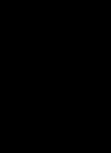

In [6]:
Image(S.eslo_tiny('data/dtm_local/sample/nofuglen_slope.tif', res=200))

In [ ]:
gdalwarp -te_srs WGS84 -te 15.3 68.6 15.5 68.7 nolofoten_trr_dtm.tif data/dtm_local/nolofoten_trr_dtm.tif


In [13]:
# 45 minutes per file

for area in ["nolofoten", "nolyngen"]:
    S.check_run(f"eval \"$(mamba shell hook --shell bash)\" && mamba activate maps && pwd && gdaldem slope {S.DFLT_OPT} data/dtm_local/{area}_dtm.tif data/slope_local/{area}_slope.tif")

/home/eoubrayrie/mapproj/eslope/development
]9;4;1;20.                                                   - estimated remaining time: 01:34:1]9;4;1;50..                                                  - estimated remaining time: 01:33:2]9;4;1;70...                                                 - estimated remaining time: 01:30:4]9;4;1;100...10                                               - estimated remaining time: 01:29:0]9;4;1;120...10.                                              - estimated remaining time: 01:26:5]9;4;1;150...10..                                             - estimated remaining time: 01:24:5]9;4;1;170...10...                                            - estimated remaining time: 01:22:3]9;4;1;200...10...20                                          - estimated remaining time: 01:19:5]9;4;1;220...10...20.                                         - estimated remaining time: 01:17:1]9;4;1;250...10...20..                                        - es

CalledProcessError: Command 'eval "$(mamba shell hook --shell bash)" && mamba activate maps && pwd &&gdaldem slope -co COMPRESS=ZSTD -co PREDICTOR=2 -co ZSTD_LEVEL=3 -co TILED=YES -co blockXsize=1024 -co blockYsize=1024 -co BIGTIFF=YES -co SPARSE_OK=TRUE -co NUM_THREADS=ALL_CPUS  data/dtm_local/nolyngen_dtm.tif data/slope_local/nolyngen_slope.tif' returned non-zero exit status 1.

In [ ]:
S.check_run("gdalinfo data/dtm_local/nolofoten.pmtiles")

ERROR 4: `data/dtm_local/mapterhorn-6-34-15-no-lofoten.pmtiles' not recognized as being in a supported file format.
gdalinfo failed - unable to open 'data/dtm_local/mapterhorn-6-34-15-no-lofoten.pmtiles'. Did you intend to call ogrinfo?


CalledProcessError: Command 'gdalinfo data/dtm_local/mapterhorn-6-34-15-no-lofoten.pmtiles' returned non-zero exit status 1.

ERROR 1: gdal: Missing command name.
Usage: gdal <COMMAND> [OPTIONS]
where <COMMAND> is one of:
  - convert:  Convert a dataset (shortcut for 'gdal raster convert' or 'gdal vector convert').
  - dataset:  Commands to manage datasets.
  - driver:   Command for driver specific operations.
  - info:     Return information on a dataset (shortcut for 'gdal raster info' or 'gdal vector info').
  - mdim:     Multidimensional commands.
  - pipeline: Process a dataset applying several steps.
  - raster:   Raster commands.
  - vector:   Vector commands.
  - vsi:      GDAL Virtual System Interface (VSI) commands.

Try 'gdal --help' for help.

'gdal <FILENAME>' can also be used as a shortcut for 'gdal info <FILENAME>'.
And 'gdal read <FILENAME> ! ...' as a shortcut for 'gdal pipeline <FILENAME> ! ...'.

For more details, consult https://gdal.org/programs/index.html

The project reserves the right to modify, rename, reorganize, and change the behavior of the utility
until it is officially frozen in